This notebook to train sequence to sequence model for Arabic punctuation prediction. This project followed the [Neural Machine Translation]((https://www.tensorflow.org/tutorials/text/nmt_with_attention)) which available from TensorFlow.


### Import necessary libraries




In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle

import numpy as np
import os
import time
import pandas as pd
import keras
from nltk.translate.bleu_score import corpus_bleu
from time import sleep
import sys

from tqdm import tqdm

Using TensorFlow backend.


## Prepare data
In this step, we convert input and output files to numeric sequence with length 10 as the maximum length.

In [0]:
def preprocess_sentence(file_name):
    '''
    DESCRIPTION:
    This function to read the file, then add <start> and <end> as a tag in begin and end for each sequence.
    INPUT: 
    file_name: file name
    OUTPUT: 
    text: text after preprocess
    ''' 
    with open(file_name , 'r', encoding='windows-1256') as f:
        text = f.readlines()

    text = ['<start> '+ t.replace('\n','') + ' <end>' for t in text]
    return text


def calculate_max_length(tensor):
    '''
    DESCRIPTION:
    This function to Calculates the max length in tensor
    INPUT: 
    tensor: input tensor
    OUTPUT: 
    _: max length of tensor
    ''' 
    return max(len(t) for t in tensor)

def tokenize(text):
    '''
    DESCRIPTION:
    This function to convert inputs to numeric sequences with the maximum length
    INPUT: 
    text: list of string
    OUTPUT: 
    tokenizer: object of converted text into a sequence of integer
    text_vector: vector of converted text into a sequence of integer
    max_length: max length in text_vector
    ''' 

    # Choose the top 9000 words from the vocabulary
    top_k = 9000
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>",filters='')
    tokenizer.fit_on_texts(text)
    train_seqs = tokenizer.texts_to_sequences(text)

    #add a word for padding 
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    # Create the tokenized vectors
    text_seqs = tokenizer.texts_to_sequences(text)

    # Pad each vector to the max_length of the vector
    text_vector = tf.keras.preprocessing.sequence.pad_sequences(text_seqs, padding='post')

    # Calculates the max_length, which is used to store the attention weights
    max_length = calculate_max_length(text_seqs)
    
    return tokenizer, text_vector,max_length

In [0]:
# prepare input data
input = preprocess_sentence('input_pun.txt')
input_tokenizer, input_tensor ,input_max_length = tokenize(input)

In [0]:
# prepare output data
target = preprocess_sentence('output_pun.txt')
target_tokenizer, target_tensor ,target_max_length = tokenize(target)

In [5]:
# data shapes
(input_tensor.shape),(target_tensor.shape) 

((26000, 12), (26000, 12))

In [6]:
def convert(tokenizer, tensor):
    '''
    DESCRIPTION:
    This function to convert index to word for input tensor
    INPUT: 
    tokenizer: object of converted text into a sequence of integer
    tensor: list of integer
    OUTPUT: 
    None
    ''' 
    for t in tensor:
        if t!=0:
              print ("%d ----> %s" % (t, tokenizer.index_word[t]))
    
print ("Input Language; index to word mapping")
convert(input_tokenizer, input_tensor[0])  
print ("Output Language; index to word mapping")
convert(target_tokenizer, target_tensor[0]) 

Input Language; index to word mapping
2 ----> <start>
2760 ----> تم
7016 ----> إعداد
39 ----> هذا
1 ----> <unk>
1 ----> <unk>
3667 ----> بواسطة
1 ----> <unk>
7017 ----> الشاملة
1956 ----> الكتاب
48 ----> شرح
3 ----> <end>
Output Language; index to word mapping
3 ----> <start>
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
5 ----> :
2 ----> space
4 ----> <end>


### Data Visualization

In [7]:
target_plot = pd.DataFrame(list(target_tokenizer.word_counts.items())) 
target_plot

,0,1
0,<start>,26000
1,space,218354
2,:,12962
3,<end>,26000
4,.,12259
5,؛,3601
6,،,12614
7,؟,210


<BarContainer object of 8 artists>

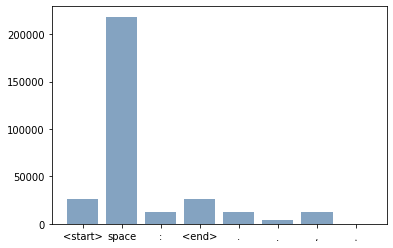

In [8]:
plt.xticks(fontsize =10)
plt.bar(target_plot[0],target_plot[1], color=(0.2, 0.4, 0.6, 0.6))

### Create dataset

In [0]:
BUFFER_SIZE = len(input_tensor)
BATCH_SIZE = 256
steps_per_epoch = len(input_tensor)//BATCH_SIZE
embedding_dim = 128
units = 1024
vocab_inp_size = len(input_tokenizer.word_index)+1
vocab_tar_size = len(target_tokenizer.word_index)+1

# create dataset
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [10]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([Dimension(256), Dimension(12)]),
 TensorShape([Dimension(256), Dimension(12)]))

## Encoder and decoder model

In this part of the code, we used the same technique of Neural Machine Translation provided by TensorFlow. However, we used Keras with the backend of TensorFlow. For more details can visit [Neural machine translation with attention tutorial](https://www.tensorflow.org/tutorials/text/nmt_with_attention).

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.keras.layers.Activation(activation = "tanh")(tf.keras.layers.Add()([self.W1(values), self.W2(hidden_with_time_axis)])))    

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.keras.layers.Activation(activation = "softmax")(tf.keras.layers.Permute((2, 1))(score))
        attention_weights = tf.keras.layers.Permute((2, 1))(attention_weights)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = tf.keras.layers.Multiply()([attention_weights, values])

        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.keras.layers.Concatenate(axis = -1)([tf.expand_dims(context_vector, 1), x])

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        #output = tf.keras.layers.Dense(self.dec_units)(output)
        # output shape == (batch_size * 1, hidden_size)
        output = tf.keras.layers.Reshape((output.shape[2],))(output)

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()

sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)


attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)



### Optimizer and loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [0]:
checkpoint_dir = './training_checkpoints5'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Train

In [0]:

@tf.function
def train_step(inp, targ, enc_hidden):
    '''
    DESCRIPTION:
    This function to train encode-decode model
    INPUT: 
    inp: input vector
    targ: target vector
    enc_hidden: encoder initial hidden state
    OUTPUT: 
    batch_loss: train loss
    ''' 

    loss = 0
    accuracy=0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
          # passing enc_output to the decoder
          predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

          loss += loss_function(targ[:, t], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


In [18]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1 Batch 0 Loss 2.1982
Epoch 1 Batch 100 Loss 0.8168
Epoch 1 Loss 0.9368
Time taken for 1 epoch 52.682173013687134 sec

Epoch 2 Batch 0 Loss 0.8119
Epoch 2 Batch 100 Loss 0.7599
Epoch 2 Loss 0.7738
Time taken for 1 epoch 24.720882177352905 sec

Epoch 3 Batch 0 Loss 0.7666
Epoch 3 Batch 100 Loss 0.6111
Epoch 3 Loss 0.6817
Time taken for 1 epoch 24.27721619606018 sec

Epoch 4 Batch 0 Loss 0.5943
Epoch 4 Batch 100 Loss 0.3905
Epoch 4 Loss 0.4679
Time taken for 1 epoch 24.67871403694153 sec

Epoch 5 Batch 0 Loss 0.5627
Epoch 5 Batch 100 Loss 0.3177
Epoch 5 Loss 0.3922
Time taken for 1 epoch 24.29068875312805 sec

Epoch 6 Batch 0 Loss 0.3334
Epoch 6 Batch 100 Loss 0.2579
Epoch 6 Loss 0.3061
Time taken for 1 epoch 24.555397510528564 sec

Epoch 7 Batch 0 Loss 0.2775
Epoch 7 Batch 100 Loss 0.2657
Epoch 7 Loss 0.4454
Time taken for 1 epoch 24.277432441711426 sec

Epoch 8 Batch 0 Loss 0.2752
Epoch 

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Predict

In [0]:
def evaluate(sentence):
    '''
    DESCRIPTION:
    This function to predict result
    INPUT: 
    sentence: input sentence 
    OUTPUT: 
    result: predict result
    sentence: input sentence 
    attention_plot: attention weights
    ''' 
    attention_plot = np.zeros((target_max_length, input_max_length))

    #sentence = preprocess_sentence(sentence)
    sentence = '<start> '+sentence + ' <end>'
    
    inputs = [input_tokenizer.texts_to_sequences([i])[0][0] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=input_max_length,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)

    for t in range(target_max_length):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizer.index_word[predicted_id] + ' '

        if target_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  '''
    DESCRIPTION:
    This function to plot attention 
    INPUT: 
    attention: attention weights
    sentence: input sentence 
    predicted_sentence: predict result

    OUTPUT: 
    None
    ''' 
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def predict(sentence):
    '''
    DESCRIPTION:
    This function to predict output sentence

    INPUT: 
    sentence: input sentence 

    OUTPUT: 
    None
    ''' 
    result, sentence, attention_plot = evaluate(sentence)

    print('Input:\n %s' % (sentence))

    predict = ''
    sentence_list = sentence.split(' ')
    sentence_list.pop(0) # remove <start>
    result_list = result.split(' ')

    for i in range(len(sentence_list)):
      if (result_list[i]=='space'):
        predict += sentence_list[i]+' '
      else:
        predict += sentence_list[i]+result_list[i]+' '
    print('Predicted punctuation:\n {}'.format(predict))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence_list, result_list)

Original Text:  قال محمد : السلام عليكم
Input:
 <start> قال محمد السلام عليكم <end>
Predicted punctuation:
 قال محمد: السلام عليكم <end> 


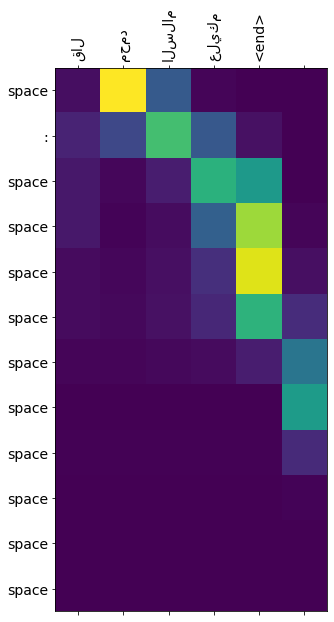

[None]

In [30]:
real_sentence = 'قال محمد : السلام عليكم'
#real_sentence = 'نجح محمد في الامتحان ؛ لأنه اجتهد في دروسه.'
sentence = 'قال محمد السلام عليكم'
print('Original Text: ',real_sentence)

in_seq = sentence.strip().split(' ')
n =10
in_sequances = [" ".join(in_seq[i:i+n]) for i in range(0, len(in_seq), n)]
[predict(s) for s in in_sequances]

In [0]:

def evaluate_model( sentences, target):
  '''
  DESCRIPTION:
  This function to evaluate model 
  INPUT: 
  sentences: input vector
  target: target vector
  OUTPUT: 
  actual: real target sentences
  predicted: predict target sentences
  ''' 
  actual, predicted = list(), list()
  outer = tqdm(range(len(sentences)),leave=True,position =0)
  for i, sentence in enumerate(sentences):
    # translate encoded source text
    #sentence = sentence.reshape((1, sentence.shape[0]))
    predict,raw_src,_ = evaluate(sentence)
    predict = predict.replace(' <end> ','')
    raw_target = target[i]
    if i < 10:
      print('src=[%s], target=[%s], predicted=[%s]' % (sentence, raw_target, predict))
    actual.append([raw_target.split()])
    predicted.append(predict.split())
    outer.update(1)

  return actual, predicted



In [26]:
input_ = np.array(input)
input_ = [ t.replace(' <end>','') for t in input_]
input_ = [ t.replace('<start> ','') for t in input_]

target_ = np.array(target)
target_ = [ t.replace(' <end>','') for t in target_]
target_ = [ t.replace('<start> ','') for t in target_]

actual, predicted = evaluate_model(input_,target_)


  0%|          | 1/26000 [00:00<1:42:50,  4.21it/s]

src=[تم إعداد هذا الملف آليا بواسطة المكتبة الشاملة الكتاب شرح], target=[space space space space space space space space : space], predicted=[space space space space space space space space : space]


  0%|          | 2/26000 [00:00<1:43:01,  4.21it/s]

src=[البهجة الوردية مصدر الكتاب موقع الإسلام [ الكتاب مشكول ومرقم], target=[space space space : space space space space space space], predicted=[space space space : space space space space space space]


  0%|          | 3/26000 [00:00<1:43:15,  4.20it/s]

src=[على سيدنا محمد وعلى آله وصحبه وسلم تسليما كثيرا رب], target=[space space space space space space space space . space], predicted=[space space space space space space space space . space]


  0%|          | 4/26000 [00:00<1:45:29,  4.11it/s]

src=[يسر واعف واختم بخير قال الشيخ الإمام العالم العلامة الرحالة], target=[space space space . space space space space space space], predicted=[space space space space space space space space space space]


  0%|          | 5/26000 [00:01<1:45:14,  4.12it/s]

src=[بسم الله الرحمن الرحيم أي أبتدئ أو أؤلف إذ كل], target=[space space space space : space space space space space], predicted=[space space space space : space space space space space]


  0%|          | 6/26000 [00:01<1:44:31,  4.14it/s]

src=[فاعل يبدأ في فعله ببسم الله يضمر ما جعل التسمية], target=[space space space space space . space space space space], predicted=[space space space space space space space space space space]


  0%|          | 7/26000 [00:01<1:45:03,  4.12it/s]

src=[مبدأ له كما أن المسافر إذا حل أو ارتحل فقال], target=[space space space space space space space space space :], predicted=[space space space space space space space space space :]


  0%|          | 8/26000 [00:01<1:45:27,  4.11it/s]

src=[والاسم مشتق من السمو وهو العلو وقيل من الوسم وهو], target=[space space space space space space : space space space], predicted=[space space space space space space : space space space]


  0%|          | 9/26000 [00:02<1:48:41,  3.99it/s]

src=[العلامة لأن كل ما سمي فقد نوه باسمه ووسم والله], target=[؛ space space space space space space space . space], predicted=[؛ space space space space space space space space space]


  0%|          | 10/26000 [00:02<1:46:48,  4.06it/s]

src=[علم للذات الواجب الوجود وأصله الإله حذفت همزته وعوض منها], target=[space space space ، space space space space space space], predicted=[space space space ، space space space space space space]


100%|██████████| 26000/26000 [1:42:25<00:00,  4.11it/s]

In [27]:

# calculate BLEU score
print('BLEU: %f' % corpus_bleu(actual, predicted))

BLEU: 0.867986
